# MusicGen

In [9]:
#@title MusicGen Setup

import os, sys, shutil, subprocess, warnings
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

def _run_quiet(cmd, check=True):
    return subprocess.run(
        cmd,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        check=check
    )

def _pip_quiet(args, check=True):
    return _run_quiet([sys.executable, "-m", "pip"] + args, check=check)

def _ensure_ffmpeg():
    if shutil.which("ffmpeg") is not None:
        return
    # In Colab, apt sometimes needs an update first.
    _run_quiet(["apt-get", "update", "-y"], check=False)
    _run_quiet(["apt-get", "install", "-y", "ffmpeg"], check=False)

def _cuda_tag_from_versions():
    """
    Returns a short CUDA tag for reporting/debugging.
    Avoids fragile attribute access when torchaudio does not expose cuda metadata.
    """
    try:
        import torch
        cuda = torch.version.cuda
        return f"cu{cuda.replace('.', '')}" if cuda else "cpu"
    except Exception:
        return "unknown"

def _torch_torchaudio_compatible():
    """
    Conservative compatibility check:
    - ensures both are importable
    - ensures both report versions
    - avoids strict CUDA string matching when the torchaudio build does not expose it
    """
    try:
        import torch, torchaudio
        _ = torch.__version__
        _ = torchaudio.__version__
        return True
    except Exception:
        return False

def setup_musicgen():
    display(Markdown(r"""
# MusicGen environment setup

## Scope
This block prepares a working **AudioCraft / MusicGen** environment in Colab.

## Goals
- Idempotent: if the environment is already usable, it does nothing
- Stable: avoids dependency reshuffling where possible
"""))

    _ensure_ffmpeg()

    # Fast path: do nothing if the stack is already importable.
    try:
        import torch
        import torchaudio
        import audiocraft
        # Optional deps: if present, good; if absent, not fatal for generation.
        try:
            import xformers
        except Exception:
            pass
        try:
            import torchdiffeq
        except Exception:
            pass

        if not _torch_torchaudio_compatible():
            raise RuntimeError("Torch / torchaudio import check failed.")

        display(Markdown(
            f"✅ Environment is ready.  \n"
            f"- torch: `{torch.__version__}`  \n"
            f"- torchaudio: `{torchaudio.__version__}`  \n"
            f"- audiocraft: `{audiocraft.__version__ if hasattr(audiocraft,'__version__') else 'imported'}`  \n"
            f"- runtime tag: `{_cuda_tag_from_versions()}`"
        ))
        return

    except Exception:
        display(Markdown("⚠️ Rebuilding the MusicGen environment (this may take a moment)."))

    # Clean potentially mismatched packages (quiet, but will still fail the cell if something truly breaks).
    pkgs_clean = ["torch", "torchaudio", "torchvision", "xformers", "audiocraft"]
    _pip_quiet(["uninstall", "-y"] + pkgs_clean, check=False)

    # Install PyTorch stack.
    # This matches your intended CUDA wheel index. If the runtime is CPU-only, pip will still resolve.
    _pip_quiet([
        "install",
        "torch", "torchvision", "torchaudio", "xformers",
        "--index-url", "https://download.pytorch.org/whl/cu126",
        "--prefer-binary"
    ], check=True)

    # Install AudioCraft without letting pip reshuffle torch.
    _pip_quiet([
        "install",
        "git+https://github.com/facebookresearch/audiocraft.git",
        "--no-deps"
    ], check=True)

    # Runtime dependencies used by AudioCraft.
    extra_pkgs = [
        "av", "einops", "flashy", "hydra-core", "omegaconf", "julius",
        "demucs", "num2words", "sentencepiece", "torchmetrics", "torchdiffeq"
    ]
    _pip_quiet(["install"] + extra_pkgs, check=True)

    # Final import check (paper-proof: fail early if something is wrong)
    import torch, torchaudio, audiocraft

    display(Markdown(
        f"✅ Environment rebuilt and ready.  \n"
        f"- torch: `{torch.__version__}`  \n"
        f"- torchaudio: `{torchaudio.__version__}`  \n"
        f"- runtime tag: `{_cuda_tag_from_versions()}`"
    ))

setup_musicgen()



# MusicGen environment setup

## Scope
This block prepares a working **AudioCraft / MusicGen** environment in Colab.

## Goals
- Idempotent: if the environment is already usable, it does nothing
- Stable: avoids dependency reshuffling where possible


✅ Environment is ready.  
- torch: `2.9.0+cu126`  
- torchaudio: `2.9.0+cu126`  
- audiocraft: `1.4.0a2`  
- runtime tag: `cu126`


# MusicGen generation

- Model: MusicGen Medium
- Preset: `Lo-Fi Study Beat`
- Duration: `15` s
- Device: `cuda`
- Output: `/content/musicgen_0.wav`


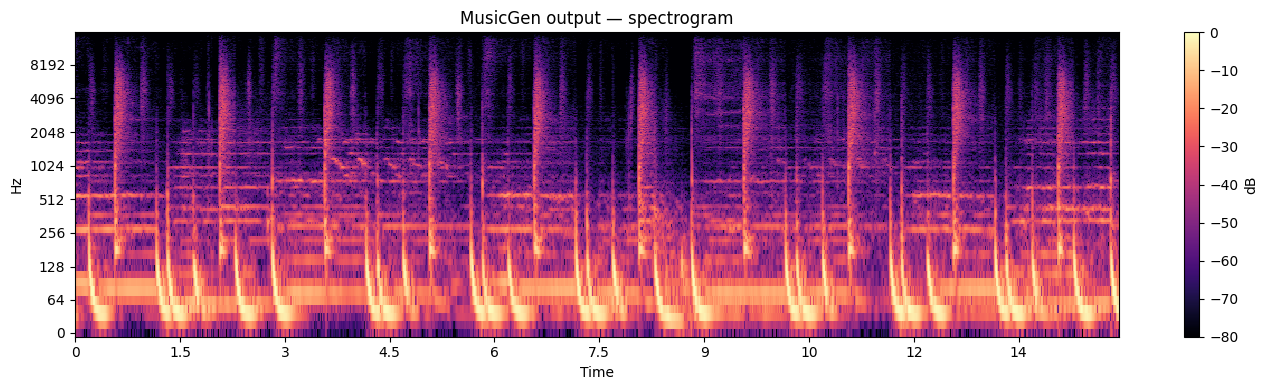

In [6]:
#@title MusicGen Generate (Medium)

import os, gc, warnings, logging, shutil
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import torch
from IPython.display import Audio, display, Markdown

warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Reduce Hugging Face download noise (first run still downloads weights)
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
try:
    from huggingface_hub.utils import disable_progress_bars
    disable_progress_bars()
except Exception:
    pass

# ============================================================
# User parameters
# ============================================================
STYLE_PRESET = "Lo-Fi Study Beat"  # @param ["Modern Radio Pop", "Classic Rock Anthem", "Smooth Jazz Lounge", "Epic Orchestral Score", "Lo-Fi Study Beat", "90s Boom Bap Hip Hop", "Emotional Solo Piano", "House Music Groove", "Acoustic Folk Ballad", "Roots Reggae Vibes"]
DURATION = 15  # @param {type:"slider", min:5, max:15, step:1}
OUTPUT_PATH = "/content/musicgen_0.wav"  # @param {"type":"string"}

PROMPT_MAP = {
    "Modern Radio Pop": "modern pop song, catchy synthesizer hook, upbeat drums, driving bassline, clean production, radio hit, 120 bpm, polished, energetic, summer vibes, billboard chart style",
    "Classic Rock Anthem": "classic rock, distorted electric guitar riff, steady powerful drum beat, bass guitar, 70s rock vibe, energetic band performance, stadium rock, high fidelity, raw energy",
    "Smooth Jazz Lounge": "smooth jazz quartet, saxophone melody, grand piano accompaniment, upright double bass, soft brush drums, relaxing, lounge atmosphere, cafe vibe, sophisticated, warm tone",
    "Epic Orchestral Score": "epic orchestral soundtrack, sweeping strings section, brass, timpani drums, heroic, cinematic, hans zimmer style, movie score, adventurous, emotional, wide stereo field",
    "Lo-Fi Study Beat": "lo-fi hip hop, chill beat, dusty vinyl crackle, mellow piano chords, slow tempo, boom bap drums, study music, relaxing, nostalgic, warm tape saturation",
    "90s Boom Bap Hip Hop": "90s old school hip hop, boom bap drum break, funky jazz samples, deep groove bassline, golden era vibe, street atmosphere, head nodding beat, 90 bpm, vinyl sound",
    "Emotional Solo Piano": "solo piano composition, classical style, emotional, melancholic, virtuoso performance, concert hall reverb, dynamic, expressive, chopin style, high quality recording",
    "House Music Groove": "classic house music, 4/4 drum beat, piano chords, groovy bassline, danceable, club vibe, 124 bpm, uplifting, soulful, ibiza sunset style, clean mix",
    "Acoustic Folk Ballad": "acoustic guitar fingerpicking, soft percussion, warm atmosphere, singer-songwriter style, emotional, intimate recording, unplugged, wooden texture, organic sound",
    "Roots Reggae Vibes": "roots reggae, offbeat skank guitar, bubbling organ, deep sub bass, one drop drum beat, island vibe, positive energy, bob marley style, relaxed, organic"
}
PROMPT = PROMPT_MAP[STYLE_PRESET]

# ============================================================
# Generation
# ============================================================
def generate_musicgen(prompt: str, duration_s: int, output_path: str) -> str:
    if not output_path.lower().endswith(".wav"):
        raise ValueError("OUTPUT_PATH must end with .wav")

    out_dir = os.path.dirname(output_path) or "."
    os.makedirs(out_dir, exist_ok=True)

    stem, _ = os.path.splitext(output_path)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    display(Markdown(f"""
# MusicGen generation

- Model: MusicGen Medium
- Preset: `{STYLE_PRESET}`
- Duration: `{duration_s}` s
- Device: `{device}`
- Output: `{output_path}`
"""))

    from audiocraft.models import MusicGen
    from audiocraft.data.audio import audio_write

    model = MusicGen.get_pretrained("facebook/musicgen-medium", device=device)
    model.set_generation_params(duration=duration_s)

    with torch.inference_mode():
        wav = model.generate([prompt], progress=False)[0]

    wav = torch.nan_to_num(wav.detach().cpu())

    written_path = str(audio_write(
        stem,
        wav,
        model.sample_rate,
        strategy="loudness",
        log_clipping=False
    ))

    expected = os.path.abspath(output_path)
    got = os.path.abspath(written_path)

    if got != expected:
        if os.path.exists(got):
            shutil.move(got, expected)
            written_path = expected
        else:
            raise RuntimeError(f"Unexpected output path.\nExpected: {expected}\nGot: {got}")

    # Playback
    y, sr = librosa.load(written_path, sr=None, mono=True)
    display(Audio(y, rate=sr))

    # Cleanup
    del model, wav
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return written_path

# ============================================================
# Spectrogram
# ============================================================
def show_spectrogram(audio_path: str):
    y, sr = librosa.load(audio_path, sr=None, mono=True)

    n_fft = 2048
    hop = 512
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop, window="hann", center=False))
    D = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(14, 4))
    librosa.display.specshow(D, sr=sr, hop_length=hop, x_axis="time", y_axis="log", cmap="magma")
    plt.title("MusicGen output — spectrogram")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

# ============================================================
# Execution
# ============================================================
final_path = generate_musicgen(PROMPT, DURATION, OUTPUT_PATH)
show_spectrogram(final_path)


# Apollo


# Pre-conditioning (between MusicGen and Apollo)

This step applies:
- a light high-pass filter to reduce DC/sub-rumble,
- peak-based gain staging to standardize headroom for the restoration stage.

Input: `/content/musicgen_0.wav` → Output: `/content/musicgen_pc_0.wav`


- HPF: 25.0 Hz (order 2)  
- Target peak: -3.00 dBFS  
- Peak (in): 0.00 dBFS  
- Peak (after HPF): 0.14 dBFS  
- Gain applied: -3.14 dB  
- Peak (out): -3.00 dBFS


## Low-frequency focus (0–120 Hz)

This view is used to confirm that the HPF mainly affects the intended sub region.
- Mean power change below 30 Hz: `-4.36 dB`


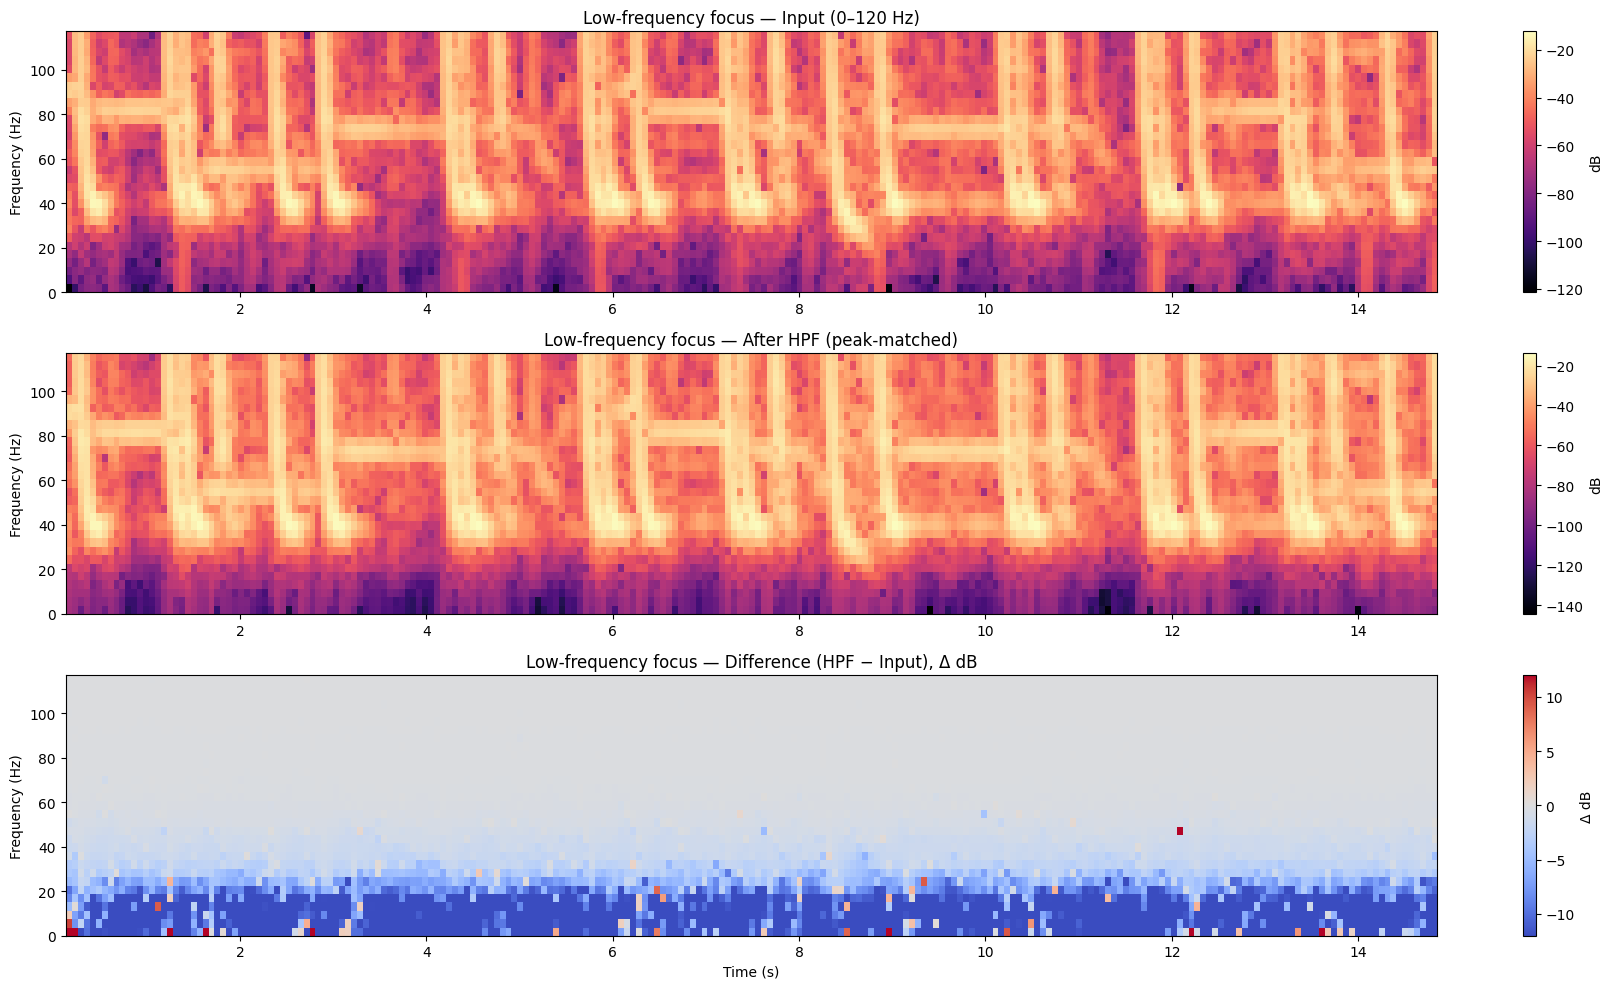

In [7]:
#@title Pre-conditioning — HPF + Gain staging

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, stft
from IPython.display import display, Markdown

# ============================================================
# User parameters
# ============================================================
INPUT_PATH  = "/content/musicgen_0.wav"      # @param {"type":"string"}
OUTPUT_PATH = "/content/musicgen_pc_0.wav"   # @param {"type":"string"}

# ============================================================
# Processing parameters
# ============================================================
HIGHPASS_CUTOFF_HZ = 25.0
HIGHPASS_ORDER    = 2

TARGET_PEAK_DBFS  = -3.0  # gain only (no limiter)

# Low-frequency view
N_PERSEG_LOW      = 8192
N_OVERLAP_LOW     = 6144
LOW_ZOOM_MAX_HZ   = 120.0
DIFF_DB_RANGE     = 12.0

EPS = 1e-12
MAG_EPS = 1e-9

# ============================================================
# Utilities
# ============================================================
def dbfs_to_linear(db):
    return 10 ** (db / 20)

def linear_to_dbfs(x):
    return 20 * np.log10(np.maximum(x, EPS))

def highpass_filter(audio, sr, cutoff_hz, order):
    nyq = sr / 2.0
    if cutoff_hz <= 0 or cutoff_hz >= nyq:
        raise ValueError(f"Invalid HPF cutoff: {cutoff_hz} Hz (Nyquist {nyq:.1f} Hz)")
    b, a = butter(order, cutoff_hz / nyq, btype="highpass")
    return filtfilt(b, a, audio, axis=0)

def stft_mag_db(x, sr, nperseg, noverlap):
    f, t, Z = stft(
        x, fs=sr,
        nperseg=nperseg,
        noverlap=noverlap,
        window="hann",
        padded=False,
        boundary=None
    )
    mag = np.abs(Z)
    mag_db = 20.0 * np.log10(mag + MAG_EPS)
    return f, t, mag, mag_db

# ============================================================
# Load
# ============================================================
audio_in, sr = sf.read(INPUT_PATH, always_2d=True)
audio_in = np.asarray(audio_in, dtype=np.float32)

if audio_in.ndim != 2 or audio_in.shape[0] < 2:
    raise ValueError("Input audio is invalid or too short.")
if sr <= 0:
    raise ValueError("Invalid sample rate.")

# ============================================================
# Purpose (brief)
# ============================================================
display(Markdown(f"""
# Pre-conditioning (between MusicGen and Apollo)

This step applies:
- a light high-pass filter to reduce DC/sub-rumble,
- peak-based gain staging to standardize headroom for the restoration stage.

Input: `{INPUT_PATH}` → Output: `{OUTPUT_PATH}`
"""))

# ============================================================
# A) HPF
# ============================================================
audio_hp = highpass_filter(audio_in, sr, HIGHPASS_CUTOFF_HZ, HIGHPASS_ORDER)

# ============================================================
# B) Gain staging (peak)
# ============================================================
peak_in = float(np.max(np.abs(audio_in)))
peak_hp = float(np.max(np.abs(audio_hp)))

target_peak = dbfs_to_linear(TARGET_PEAK_DBFS)
gain = float(target_peak / max(peak_hp, EPS))

audio_out = audio_hp * gain
peak_out = float(np.max(np.abs(audio_out)))

sf.write(OUTPUT_PATH, audio_out, sr, subtype="FLOAT")

display(Markdown(
    f"- HPF: {HIGHPASS_CUTOFF_HZ:.1f} Hz (order {HIGHPASS_ORDER})  \n"
    f"- Target peak: {TARGET_PEAK_DBFS:.2f} dBFS  \n"
    f"- Peak (in): {linear_to_dbfs(peak_in):.2f} dBFS  \n"
    f"- Peak (after HPF): {linear_to_dbfs(peak_hp):.2f} dBFS  \n"
    f"- Gain applied: {linear_to_dbfs(gain):.2f} dB  \n"
    f"- Peak (out): {linear_to_dbfs(peak_out):.2f} dBFS"
))

# ============================================================
# Low-frequency focus view (gain-neutral)
# ============================================================
mono_in = np.mean(audio_in, axis=1)
mono_hp = np.mean(audio_hp, axis=1)

# peak-match for analysis (isolates HPF effect from gain staging)
mono_hp_norm = mono_hp / (np.max(np.abs(mono_hp)) + EPS) * (np.max(np.abs(mono_in)) + EPS)

fL, tL, mag_in_L, spec_in_L = stft_mag_db(mono_in, sr, N_PERSEG_LOW, N_OVERLAP_LOW)
_,  _, mag_hp_L, spec_hp_L = stft_mag_db(mono_hp_norm, sr, N_PERSEG_LOW, N_OVERLAP_LOW)

diff_L = spec_hp_L - spec_in_L
low_idx = fL <= LOW_ZOOM_MAX_HZ
lf_idx = fL < 30.0

# compact LF attenuation number (power-domain ratio)
if np.any(lf_idx):
    P_before = float(np.mean((mag_in_L[lf_idx, :] ** 2)))
    P_after  = float(np.mean((mag_hp_L[lf_idx, :] ** 2)))
    lf_delta_db = 10.0 * np.log10((P_after + EPS) / (P_before + EPS))
else:
    lf_delta_db = float("nan")

display(Markdown(f"""
## Low-frequency focus (0–{LOW_ZOOM_MAX_HZ:.0f} Hz)

This view is used to confirm that the HPF mainly affects the intended sub region.
- Mean power change below 30 Hz: `{lf_delta_db:.2f} dB`
"""))

plt.figure(figsize=(18, 10))

plt.subplot(3, 1, 1)
plt.imshow(spec_in_L[low_idx], origin="lower", aspect="auto",
           extent=[tL[0], tL[-1], fL[low_idx][0], fL[low_idx][-1]], cmap="magma")
plt.title(f"Low-frequency focus — Input (0–{LOW_ZOOM_MAX_HZ:.0f} Hz)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="dB")

plt.subplot(3, 1, 2)
plt.imshow(spec_hp_L[low_idx], origin="lower", aspect="auto",
           extent=[tL[0], tL[-1], fL[low_idx][0], fL[low_idx][-1]], cmap="magma")
plt.title("Low-frequency focus — After HPF (peak-matched)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="dB")

plt.subplot(3, 1, 3)
plt.imshow(diff_L[low_idx], origin="lower", aspect="auto",
           extent=[tL[0], tL[-1], fL[low_idx][0], fL[low_idx][-1]],
           cmap="coolwarm", vmin=-DIFF_DB_RANGE, vmax=DIFF_DB_RANGE)
plt.title("Low-frequency focus — Difference (HPF − Input), Δ dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Δ dB")

plt.tight_layout()
plt.show()



# Environment setup

This step prepares **Apollo** and all required dependencies.
The setup is fully autonomous: no manual model or file handling is required from the user.

The goal is to ensure a reproducible and self-contained environment.


✅ Apollo environment is ready.


# Apollo inference

Apollo is used here strictly as a **restoration tool**, not as a creative effect.

Objective: reduce noise and low-level artifacts while preserving:
- dynamics
- transients
- spectral balance


✅ Inference completed successfully.


# Contextual analysis (full-band, gain-matched)

This section provides contextual verification that Apollo behaves as a conservative restoration process.
The analysis does not aim to rate quality, but to check consistency with the intended behavior.

Expected behavior
- Preserved dynamics
- No global equalization
- Non-structured noise or grain reduction

Undesired behavior
- Hidden compression
- Transient smearing
- Harmonic hallucination


## Full-band time–frequency comparison

The plots below show:
- Input signal (pre-Apollo)
- Output signal (post-Apollo, gain-matched)
- Local spectral differences (POST − PRE)

They provide a direct visual reference for identifying structured vs. non-structured changes.

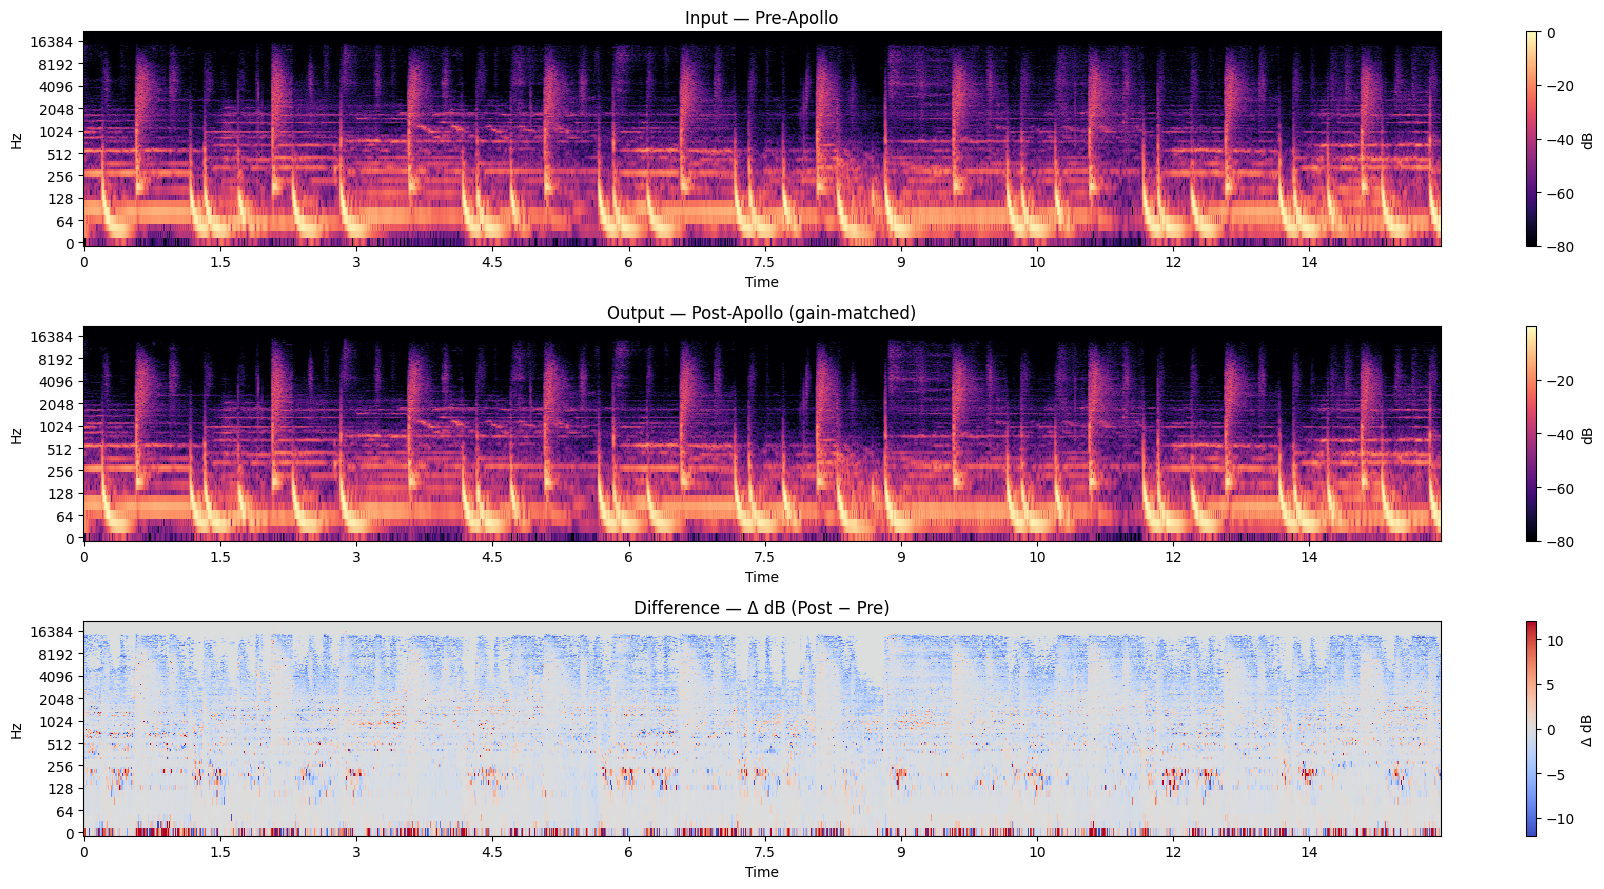

## Comparative listening

The following players correspond to the signals used in the plots above.

**Input — Pre-Apollo**

**Output — Post-Apollo**

In [8]:
#@title Apollo Restoration

import os, sys, shutil, subprocess, gc, warnings
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
from scipy.signal import resample_poly
from IPython.display import Audio, display, Markdown

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# ============================================================
# User parameters
# ============================================================
INPUT_PATH  = "/content/musicgen_pc_0.wav"   # @param {"type":"string"}
OUTPUT_PATH = "/content/apollo_0.wav"        # @param {"type":"string"}
CHUNK_SIZE  = 5                              # @param {"type":"integer"}

# ============================================================
# Constants
# ============================================================
APOLLO_DIR = "/content/Apollo"

CKPT_PATH = f"{APOLLO_DIR}/model/apollo_model_uni.ckpt"
CFG_PATH  = f"{APOLLO_DIR}/configs/config_apollo_uni.yaml"
INF_PATH  = f"{APOLLO_DIR}/inference_cli.py"

OVERLAP = 2

# Minimal verification view
ANALYSIS_SR = 44100
N_FFT = 2048
HOP   = 512
DIFF_DB_RANGE = 12.0
EPS = 1e-12

# Bounded alignment (visualization only)
MAX_ALIGN_SEC = 0.05
ALIGN_SEG_SEC = 8.0

RESAMPLE_WINDOW = ("kaiser", 5.0)

# ============================================================
# Helpers
# ============================================================
def _run_quiet(cmd, check=True):
    return subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=check)

def _pip_quiet(args, check=True):
    return _run_quiet([sys.executable, "-m", "pip"] + args, check=check)

def _ensure_file(path: str, label: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {label}: {path}")

def _sanitize(x: np.ndarray) -> np.ndarray:
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)

def _resample_to(x: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    x = _sanitize(x)
    if int(orig_sr) == int(target_sr):
        return x
    g = int(np.gcd(int(orig_sr), int(target_sr)))
    up = int(target_sr // g)
    down = int(orig_sr // g)
    y = resample_poly(x, up, down, window=RESAMPLE_WINDOW)
    return _sanitize(y)

def _bounded_align(pre: np.ndarray, post: np.ndarray, sr: int) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Global bounded alignment (±MAX_ALIGN_SEC) computed on an energetic excerpt.
    Used only to make the Δ spectrogram interpretable (visualization hygiene).
    """
    max_shift = int(MAX_ALIGN_SEC * sr)

    m0 = min(len(pre), len(post))
    pre0 = pre[:m0]
    post0 = post[:m0]

    if m0 < 2 * HOP:
        return pre0, post0, 0.0

    frame_rms = librosa.feature.rms(y=pre0, frame_length=N_FFT, hop_length=HOP, center=False)[0]
    peak_frame = int(np.argmax(frame_rms))
    peak_sample = peak_frame * HOP

    seg_len = int(min(ALIGN_SEG_SEC, m0 / sr) * sr)
    seg_len = m0 if m0 < int(1.0 * sr) else seg_len
    seg_len = max(1, seg_len)

    seg_start = int(np.clip(peak_sample - seg_len // 2, 0, max(0, m0 - seg_len)))
    seg_end   = seg_start + seg_len

    a = pre0[seg_start:seg_end].astype(np.float64)
    b = post0[seg_start:seg_end].astype(np.float64)

    max_shift = min(max_shift, len(a) - 1) if len(a) > 1 else 0
    if max_shift <= 0:
        return pre0, post0, 0.0

    a = a - np.mean(a)
    b = b - np.mean(b)
    a = a / (np.sqrt(np.mean(a * a)) + EPS)
    b = b / (np.sqrt(np.mean(b * b)) + EPS)

    lags = np.arange(-max_shift, max_shift + 1)
    scores = np.empty_like(lags, dtype=np.float64)

    for i, lag in enumerate(lags):
        if lag >= 0:
            aa = a[:len(a) - lag]
            bb = b[lag:]
        else:
            aa = a[-lag:]
            bb = b[:len(b) + lag]
        scores[i] = float(np.dot(aa, bb) / (len(aa) + EPS))

    best = int(lags[int(np.argmax(scores))])

    if best > 0:
        post0 = post0[best:]
        pre0  = pre0[:len(post0)]
    elif best < 0:
        pre0  = pre0[-best:]
        post0 = post0[:len(pre0)]

    m = min(len(pre0), len(post0))
    return pre0[:m], post0[:m], float(best)

# ============================================================
# Setup
# ============================================================
def setup_apollo():
    display(Markdown(r"""
# Environment setup

This step prepares **Apollo** and all required dependencies.
The setup is fully autonomous: no manual model or file handling is required from the user.

The goal is to ensure a reproducible and self-contained environment.
"""))

    # Some Apollo environments are not compatible with numpy>=2
    try:
        import numpy as _np
        if _np.__version__.startswith("2"):
            _pip_quiet(["install", "numpy<2", "-U", "--force-reinstall"], check=True)
    except Exception:
        pass

    need_download = (not os.path.exists(CKPT_PATH)) or (not os.path.exists(CFG_PATH)) or (not os.path.exists(INF_PATH))

    if need_download:
        if os.path.exists(APOLLO_DIR):
            shutil.rmtree(APOLLO_DIR)

        _run_quiet(["git", "clone", "--depth", "1", "https://github.com/JusperLee/Apollo.git", APOLLO_DIR], check=True)

        os.makedirs(f"{APOLLO_DIR}/model", exist_ok=True)
        os.makedirs(f"{APOLLO_DIR}/configs", exist_ok=True)

        _run_quiet([
            "wget", "-q", "-O", CKPT_PATH,
            "https://github.com/deton24/Lew-s-vocal-enhancer-for-Apollo-by-JusperLee/releases/download/uni/apollo_model_uni.ckpt"
        ], check=True)

        _run_quiet([
            "wget", "-q", "-O", CFG_PATH,
            "https://github.com/deton24/Lew-s-vocal-enhancer-for-Apollo-by-JusperLee/releases/download/uni/config_apollo_uni.yaml"
        ], check=True)

        _run_quiet([
            "wget", "-q", "-O", INF_PATH,
            "https://raw.githubusercontent.com/jarredou/Apollo-Colab-Inference/main/inference.py"
        ], check=True)

        _pip_quiet(["install", "-q", "omegaconf", "ml_collections", "soundfile", "librosa", "numpy<2"], check=True)

    _ensure_file(CKPT_PATH, "checkpoint")
    _ensure_file(CFG_PATH, "config")
    _ensure_file(INF_PATH, "inference script")

    display(Markdown("✅ Apollo environment is ready."))

# ============================================================
# Inference
# ============================================================
def run_apollo(in_wav: str, out_wav: str):
    display(Markdown(r"""
# Apollo inference

Apollo is used here strictly as a **restoration tool**, not as a creative effect.

Objective: reduce noise and low-level artifacts while preserving:
- dynamics
- transients
- spectral balance
"""))

    _ensure_file(in_wav, "input wav")

    base = os.getcwd()
    try:
        os.chdir(APOLLO_DIR)

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        cmd = [
            sys.executable, "inference_cli.py",
            "--in_wav", in_wav,
            "--out_wav", out_wav,
            "--chunk_size", str(int(CHUNK_SIZE)),
            "--overlap", str(int(OVERLAP)),
            "--ckpt", "model/apollo_model_uni.ckpt",
            "--config", "configs/config_apollo_uni.yaml"
        ]

        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

        if proc.returncode != 0:
            tail = proc.stdout[-2000:] if proc.stdout else ""
            print(tail)
            raise RuntimeError("Apollo inference failed.")

    finally:
        os.chdir(base)

    _ensure_file(out_wav, "output wav")
    display(Markdown("✅ Inference completed successfully."))

# ============================================================
# Contextual analysis (minimal, full-band, gain-matched)
# ============================================================
def contextual_check(in_path: str, out_path: str):
    display(Markdown(r"""
# Contextual analysis (full-band, gain-matched)

This section provides contextual verification that Apollo behaves as a conservative restoration process.
The analysis does not aim to rate quality, but to check consistency with the intended behavior.

Expected behavior
- Preserved dynamics
- No global equalization
- Non-structured noise or grain reduction

Undesired behavior
- Hidden compression
- Transient smearing
- Harmonic hallucination
"""))

    x_in, sr_in = sf.read(in_path, always_2d=False)
    x_out, sr_out = sf.read(out_path, always_2d=False)

    if x_in.ndim > 1:
        x_in = np.mean(x_in, axis=1)
    if x_out.ndim > 1:
        x_out = np.mean(x_out, axis=1)

    x_in = _sanitize(x_in)
    x_out = _sanitize(x_out)

    x_in = _resample_to(x_in, sr_in, ANALYSIS_SR)
    x_out = _resample_to(x_out, sr_out, ANALYSIS_SR)

    # bounded alignment for a cleaner Δ view
    x_in_a, x_out_a, shift = _bounded_align(x_in, x_out, ANALYSIS_SR)

    # gain match for visualization only
    rms_in = float(np.sqrt(np.mean(x_in_a * x_in_a)))
    rms_out = float(np.sqrt(np.mean(x_out_a * x_out_a)))
    x_out_m = x_out_a * (rms_in / max(rms_out, EPS))

    display(Markdown("## Full-band time–frequency comparison\n\nThe plots below show:\n- Input signal (pre-Apollo)\n- Output signal (post-Apollo, gain-matched)\n- Local spectral differences (POST − PRE)\n\nThey provide a direct visual reference for identifying structured vs. non-structured changes."))

    # spectrograms
    S_in  = np.abs(librosa.stft(x_in_a,  n_fft=N_FFT, hop_length=HOP, window="hann", center=False))
    S_out = np.abs(librosa.stft(x_out_m, n_fft=N_FFT, hop_length=HOP, window="hann", center=False))

    ref = float(np.max(S_in)) + EPS
    D_in   = librosa.amplitude_to_db(S_in,  ref=ref)
    D_out  = librosa.amplitude_to_db(S_out, ref=ref)
    D_diff = D_out - D_in

    plt.figure(figsize=(18, 9))

    plt.subplot(3, 1, 1)
    librosa.display.specshow(D_in, sr=ANALYSIS_SR, hop_length=HOP, y_axis="log", x_axis="time", cmap="magma")
    plt.title("Input — Pre-Apollo")
    plt.colorbar(label="dB")

    plt.subplot(3, 1, 2)
    librosa.display.specshow(D_out, sr=ANALYSIS_SR, hop_length=HOP, y_axis="log", x_axis="time", cmap="magma")
    plt.title("Output — Post-Apollo (gain-matched)")
    plt.colorbar(label="dB")

    plt.subplot(3, 1, 3)
    librosa.display.specshow(D_diff, sr=ANALYSIS_SR, hop_length=HOP, y_axis="log", x_axis="time",
                             cmap="coolwarm", vmin=-DIFF_DB_RANGE, vmax=DIFF_DB_RANGE)
    plt.title("Difference — Δ dB (Post − Pre)")
    plt.colorbar(label="Δ dB")

    plt.tight_layout()
    plt.show()

    # players
    display(Markdown("## Comparative listening\n\nThe following players correspond to the signals used in the plots above."))
    display(Markdown("**Input — Pre-Apollo**"))
    display(Audio(x_in_a, rate=ANALYSIS_SR))
    display(Markdown("**Output — Post-Apollo**"))
    display(Audio(x_out_a, rate=ANALYSIS_SR))

# ============================================================
# Run
# ============================================================
setup_apollo()
run_apollo(INPUT_PATH, OUTPUT_PATH)
contextual_check(INPUT_PATH, OUTPUT_PATH)
